# House Sales in King County, USA

### Data set

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. It's a great dataset for evaluating simple regression models. The original dataset is obtained from Kaggle: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In this demo, I will use various regression methods to model the house sales price and evaluate the model with test set.

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler,RobustScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import * 

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.shape

(21613, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

**Data Impression and Variables**

The dataset has total 21 columns and price is the analysis target.

### Exploratory Analysis


##### Column statistics

In [5]:
df.describe().style.format(precision=3)  

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,4580301520.865,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,3.409,7.657,1788.391,291.509,1971.005,84.402,98077.940,47.560,-122.214,1986.552,12768.456
std,2876565571.312,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,0.651,1.175,828.091,442.575,29.373,401.679,53.505,0.139,0.141,685.391,27304.180
min,1000102.000,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049194.000,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000
75%,7308900445.000,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,4.000,8.000,2210.000,560.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


##### Distribution graph

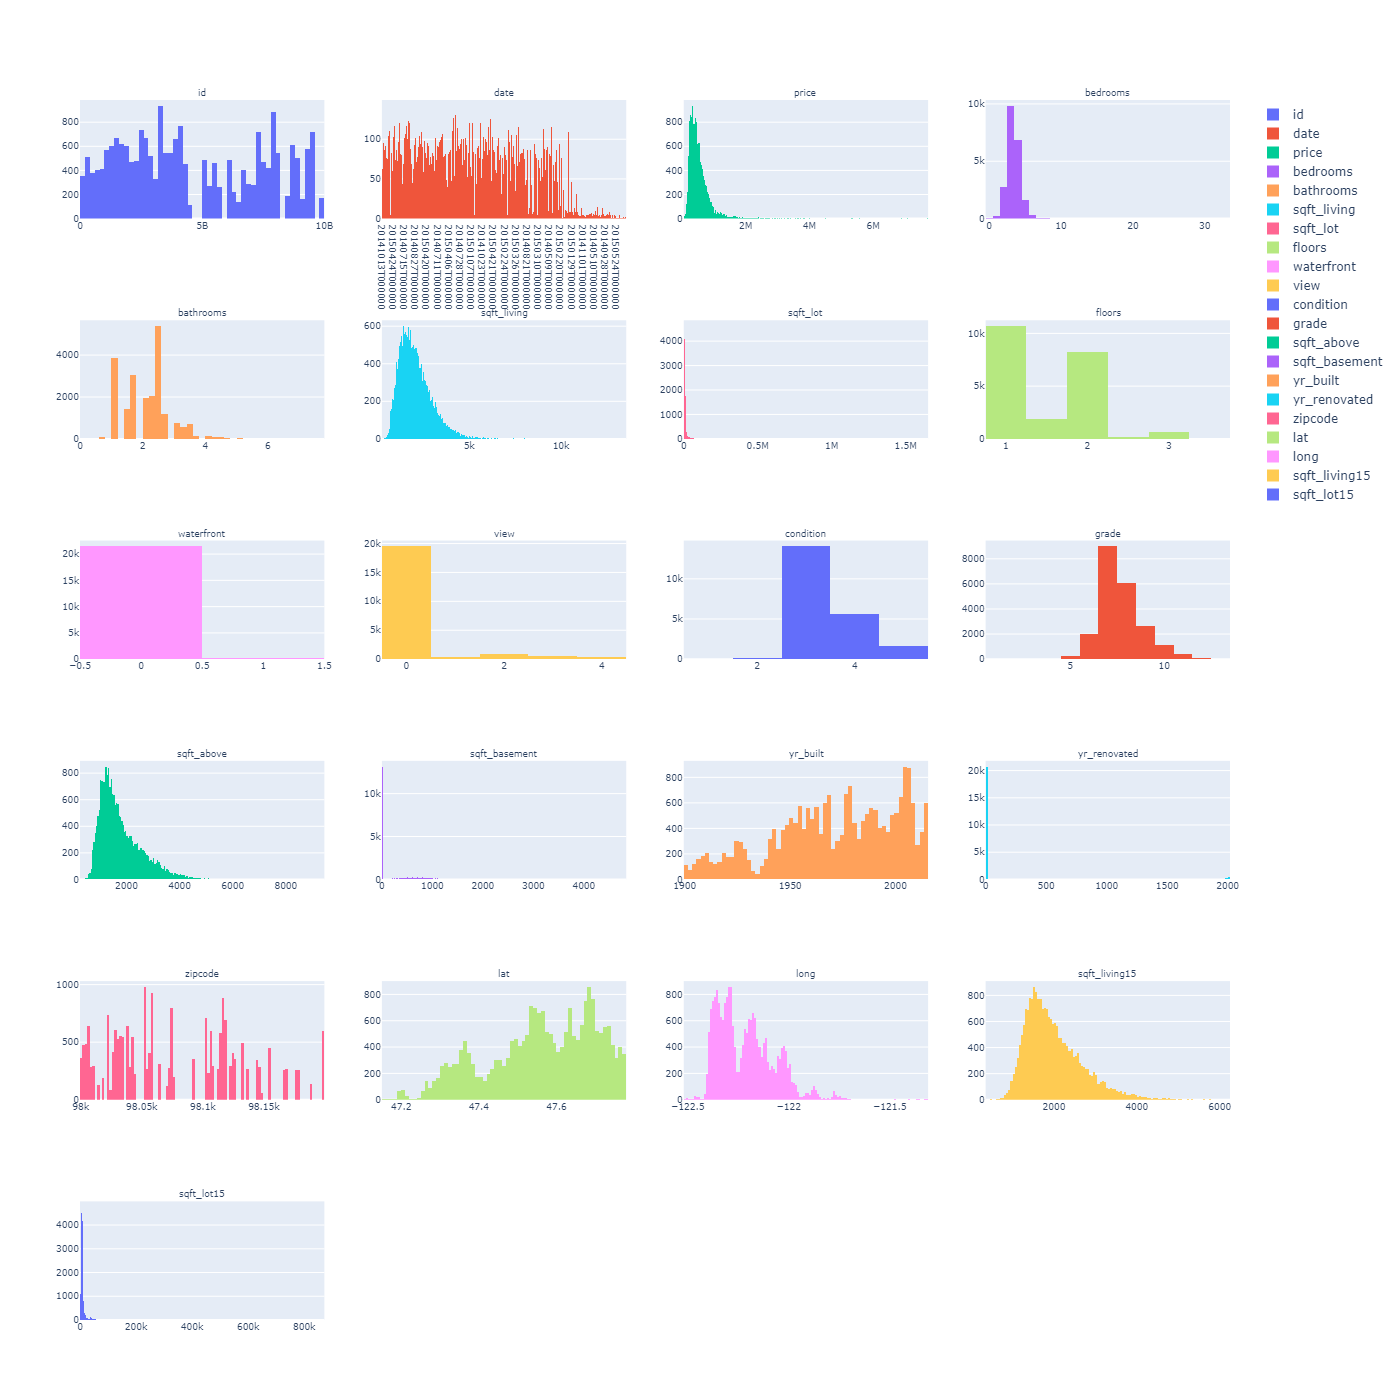

In [6]:
n_col=4
n_row=len(df.columns)//4+1

fig = make_subplots(rows=n_row, cols=n_col,
                   subplot_titles=df.columns)

for i, col in enumerate(df.columns):
    ro = i//n_col+1
    co = i%n_col+1
    fig.add_trace(go.Histogram(x=df[col], name=col),
              row=ro, col=co)



fig.update_layout(height=1400, width=1400)
fig.update_annotations(font_size=9)
fig.update_yaxes(tickfont=dict(size=9))
fig.update_xaxes(tickfont=dict(size=9))
fig.show('png')

##### Correlation table

In [7]:
df.corr().style.background_gradient().format(precision=2)  

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00


##### Scatter Matrix

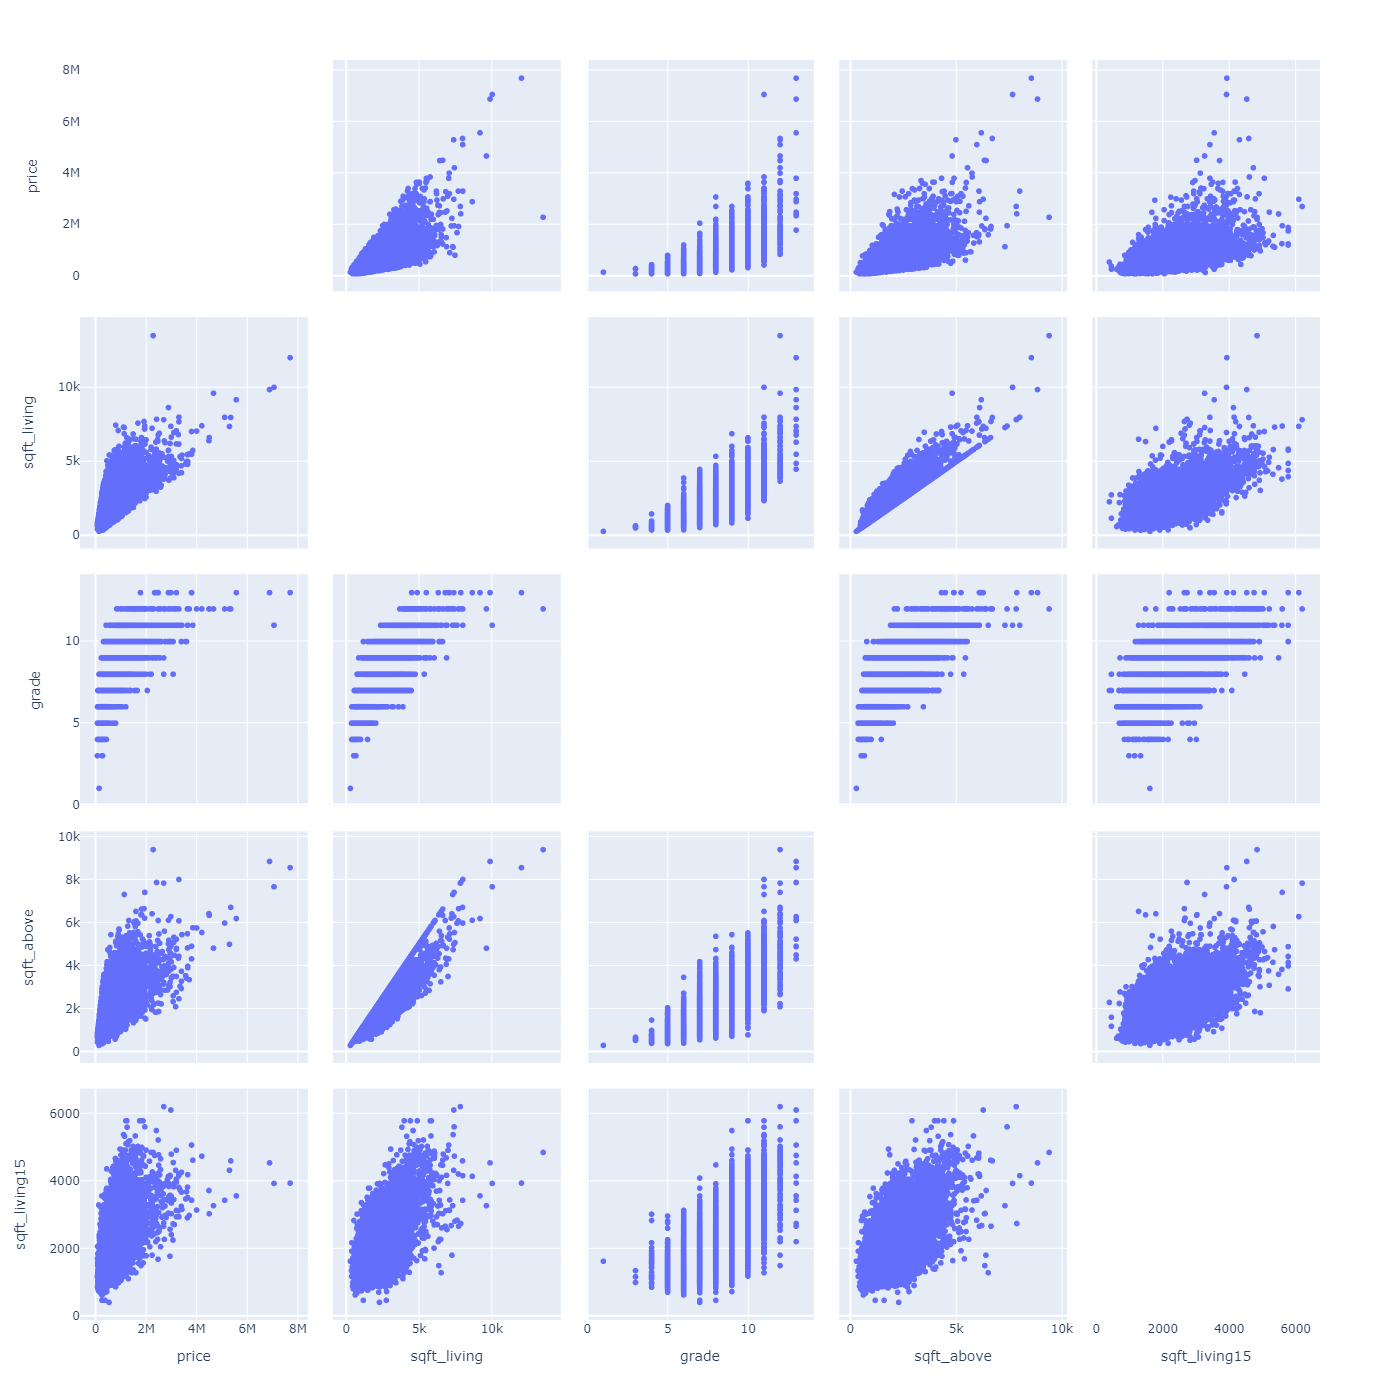

In [8]:
sc_list = df.corr()['price'].sort_values(ascending=False).head().index

fig = px.scatter_matrix(df[sc_list],width=1400, height=1400)

# disable digonal components
fig.update_traces(diagonal_visible=False)
fig.show('png')

### Data Process

'id' and 'view' columm is not relevant. 

'data' column need to be changed to have meaning.

##### Change 'date column to 'days'

In [9]:
# change data column to pd datetime
df['date'] = pd.to_datetime(df['date'])

# change date to days
df['days'] = (df['date']-df['date'].min()).dt.days

# drop 'date', 'id', and 'view' column
df_new = df.drop(['date','id','view'], axis=1)
df_new.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,days
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,164
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,221
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,299
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,221
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,292


##### Split our data into training and testing data 

In [10]:
# No spilt
x_data = df_new.drop(['price'],axis=1)
y_data = df['price']

#  spilt
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

### Construct fiting function
variables x_train, y_train, pipe, x_test, y_test 

In [11]:
# fit

metrics=[]

def model_fit(model, x_train, x_test, y_train, y_test, title='none'):
    
    # fit
    model.fit(x_train,y_train)
    
    # metrics
    coefs = model.steps[-1][-1].coef_
    prediction = model.predict(x_test)
    score = r2_score(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    
    # data for plots
    df_coef = pd.DataFrame(zip(x_train.columns, coefs), columns=['features','coef'])
    df_coef_sort = df_coef.reindex(df_coef['coef'].abs().sort_values().index)
    hist_data = [df_new['price'],prediction]
    group_labels = ['price','predicted']
    
    # plot traces1-coef, trace2-dist
    trace_coef = go.Bar(y=df_coef_sort['features'], x=df_coef_sort['coef'], orientation='h', showlegend=False)
    trace_dist = ff.create_distplot(hist_data, group_labels, show_rug=False, show_hist=False)
    
    # subplot if it is linear regression
    if len(coefs)==len(x_train.columns):
        # subplot
        fig_fit = make_subplots(rows=1, cols=2,
                                subplot_titles=['Coef.', 'Distribution'])
    
        fig_fit.add_trace(trace_coef, row=1, col=1)

        for trace in trace_dist.select_traces():
            fig_fit.add_trace(trace, row=1, col=2)

        fig_fit.update_layout(title=title,
                              height=500, width=1400,
                              legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))
        fig_fit.update_yaxes(showticklabels=False, row=1, col=2)
        fig_fit.show('png')
            
    # dist plot if it is polynomial regression
    else:
        trace_dist
        trace_dist.update_layout(title= title + ' Distribution',
                                 height=500, width=700,
                                 legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))
        trace_dist.show('png')

    print('R_Squred =',score)
    print('RMSE =',rmse)
    
    metrics.append([title , score , rmse])

### StandardScaler LinearRegression

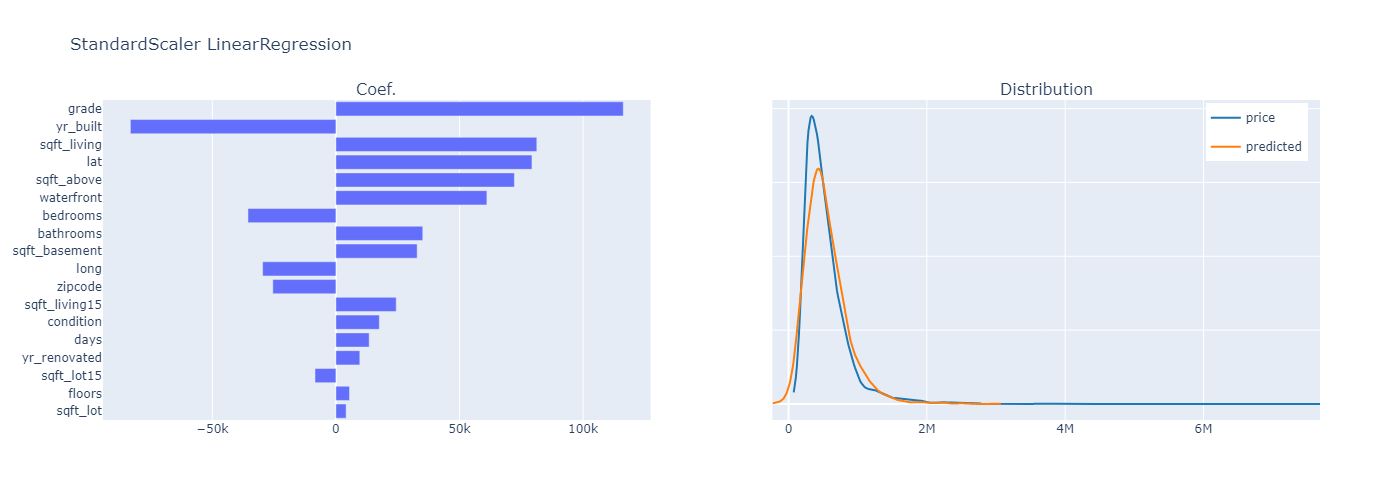

R_Squred = 0.6958429633749594
RMSE = 214432.8818226392


In [12]:
Input = [('scale',StandardScaler()), ('model',LinearRegression())]
stdscl_lnr_reg = Pipeline(Input)

model_fit(stdscl_lnr_reg,x_train, x_test, y_train, y_test, title='StandardScaler LinearRegression')

### RobustScaler LinearRegression

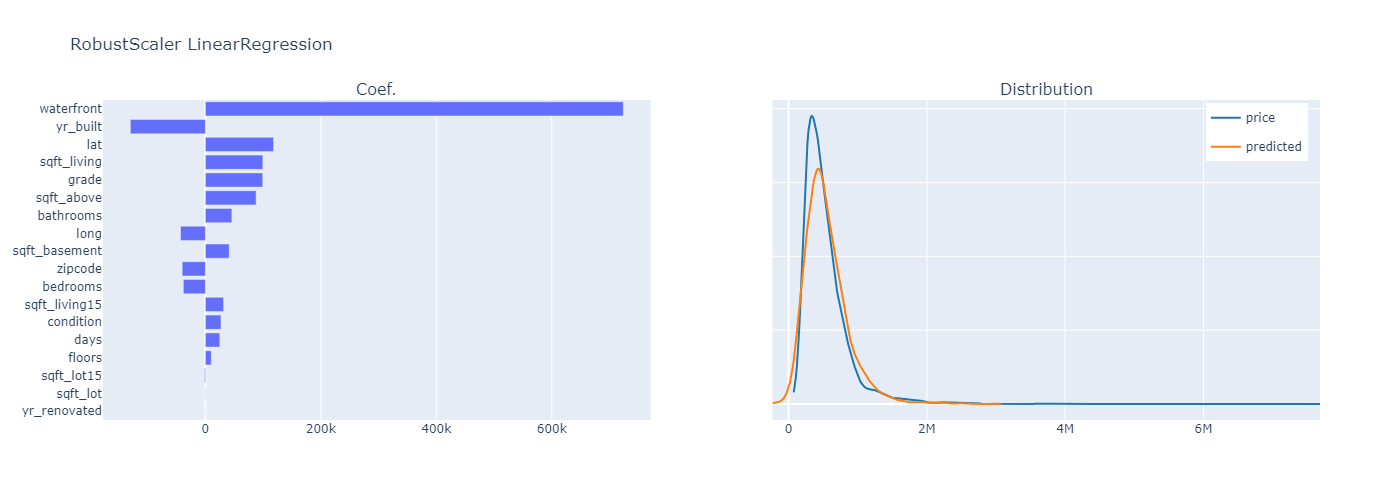

R_Squred = 0.6958429633749598
RMSE = 214432.8818226391


In [13]:
Input = [('scale', RobustScaler()), ('model',LinearRegression())]
stdscl_lnr_reg = Pipeline(Input)

model_fit(stdscl_lnr_reg,x_train, x_test, y_train, y_test, title='RobustScaler LinearRegression')

### StandardScaler RidgeRegression

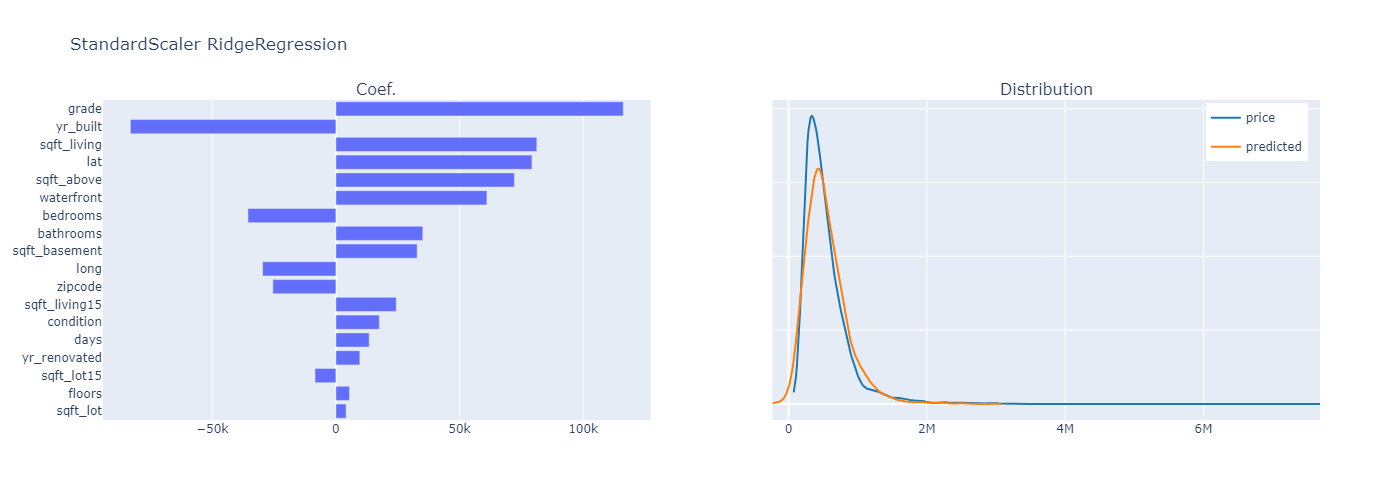

R_Squred = 0.6958410889005009
RMSE = 214433.54258055755


In [14]:
Input = [('scale',StandardScaler()), ('model',Ridge())]
stdscl_rid_reg = Pipeline(Input)

model_fit(stdscl_rid_reg,x_train, x_test, y_train, y_test, title='StandardScaler RidgeRegression')

### StandardScaler BayesianRidge

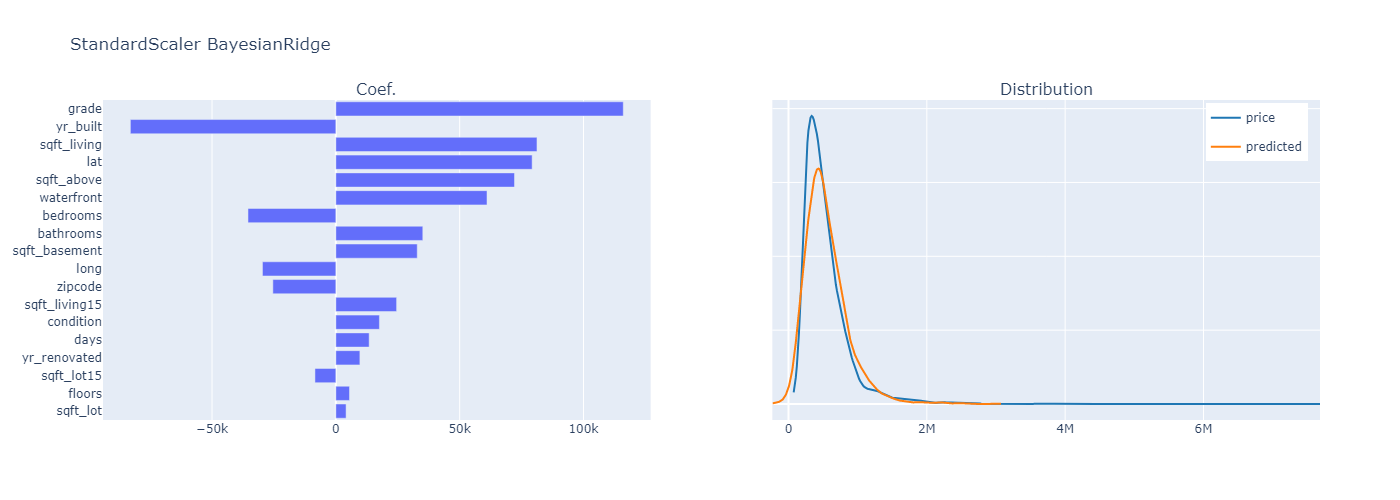

R_Squred = 0.6958162839642237
RMSE = 214442.2862039153


In [15]:
Input = [('scale',StandardScaler()), ('model',BayesianRidge())]
stdscl_bsn_reg = Pipeline(Input)

model_fit(stdscl_bsn_reg,x_train, x_test, y_train, y_test, title='StandardScaler BayesianRidge')

### StandardScaler Polynomial(2) LinearRegression

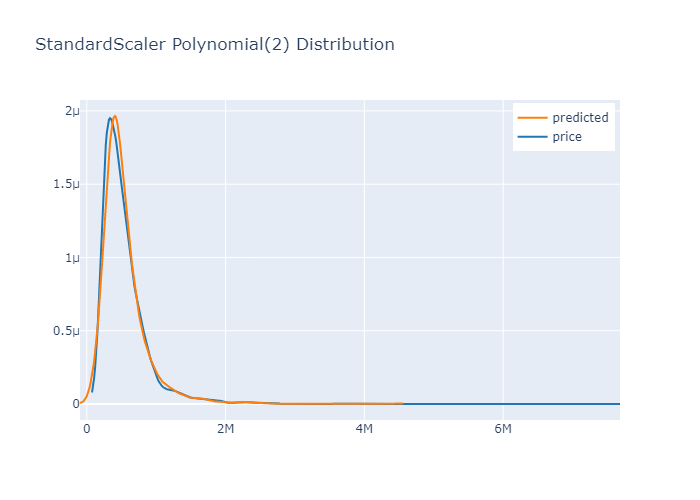

R_Squred = 0.8055552287372505
RMSE = 171451.2211535368


In [16]:
# construct pipeline - SrandardScaler - ploynomial 2nd order - linear reg
Input = [('scale',StandardScaler()),('polynomial_2', PolynomialFeatures(degree=2)),('model',LinearRegression())]
poly_2 = Pipeline(Input)

# fit
model_fit(poly_2, x_train, x_test, y_train, y_test, title='StandardScaler Polynomial(2)')

### RobustScaler Polynomial(2) LinearRegression

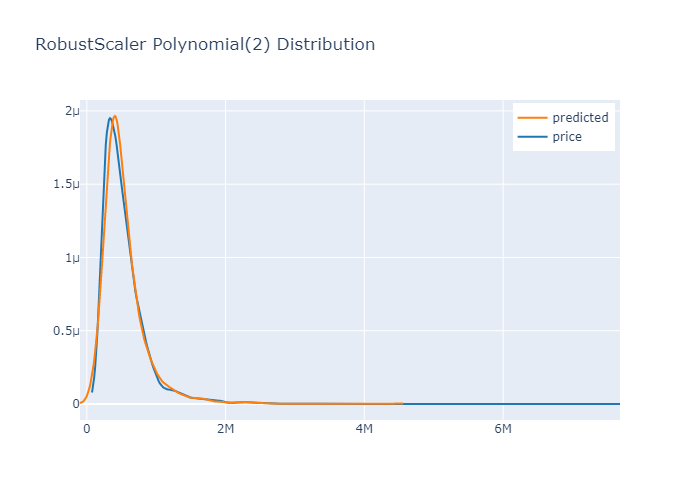

R_Squred = 0.8055556910536058
RMSE = 171451.01733023446


In [17]:
# construct pipeline - SrandardScaler - ploynomial 2nd order - linear reg
Input = [('scale',RobustScaler()),('polynomial_2', PolynomialFeatures(degree=2)),('model',LinearRegression())]
poly_2r = Pipeline(Input)

# fit
model_fit(poly_2r, x_train, x_test, y_train, y_test, title='RobustScaler Polynomial(2)')

### Summery

In [18]:
df_result = pd.DataFrame(metrics , columns=['model', 'R_Squared' , 'RMSE'])
df_result

,model,R_Squared,RMSE
0,StandardScaler LinearRegression,0.695843,214432.881823
1,RobustScaler LinearRegression,0.695843,214432.881823
2,StandardScaler RidgeRegression,0.695841,214433.542581
3,StandardScaler BayesianRidge,0.695816,214442.286204
4,StandardScaler Polynomial(2),0.805555,171451.221154
5,RobustScaler Polynomial(2),0.805556,171451.017330


### Future Works

The house sales price in king county is modeled with various linear and polynomial regression. From the results, qudratic polynomial regression with RobustScaler gave the best performance.
The distributions are skewered alot and it seems there are large outliers. From that, RubustScaler gave better metrics as expected.
As seen in scatter matrix, many of the scatter plots indicate non-linear correlation to price and qudratic polinomial gave a good metrics.

In this work, I did not use any classification. For example, 'year built' and 'year renovated' can be modified. 
Also, it might be better to use less number of indepecdent variables, for example 'living space' and 'living space 15' is highly correlated and it is not necessary to use both featuers in regression.